# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Test Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


In [6]:
# import matplotlib.pyplot as plt

# # Retrieve one batch of images from the generator
# images, labels = train_gen.next()

# # Print the dimensions of the first image
# print("Image dimensions:", images[0].shape)

# # Define the class labels
# class_labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# # Display the first six images with their labels
# fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

# for i in range(2):
#     for j in range(3):
#         # Calculate the index in the images and labels arrays
#         idx = i * 3 + j
        
#         # Get the class name from the label
#         class_name = [key for key, value in class_labels.items() if value == labels[idx]][0]
        
#         # Plot the image
#         ax[i, j].imshow(images[idx])
#         ax[i, j].set_title(f"Class: {class_name}")

# plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [13]:
# Extract data and labels from the generated batches on train set
data_train, labels_train = [], []
for _ in range(len(train_gen)):
    images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
    data_train.extend(images_train)
    labels_train.extend(batch_labels_train)

# Extract data and labels from the generated batches on test set
data_test, labels_test = [], []
for _ in range(len(test_gen)):
    images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
    data_test.extend(images_train)
    labels_test.extend(batch_labels_test)

# Extract data and labels from the generated batches on validation set
data_val, labels_val = [], []
for _ in range(len(val_gen)):
    images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
    data_val.extend(images_val)
    labels_val.extend(batch_labels_val)

# Flatten the image data
data_train_flat = np.array(data_train).reshape(len(data_train), -1)
data_test_flat = np.array(data_test).reshape(len(data_test), -1)
data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# Create Dataframes for each set. Keep class labels in order
df_train_data = pd.DataFrame(data_train_flat)
df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_train = pd.concat([df_train_data, df_train_labels], axis=1)

df_test_data = pd.DataFrame(data_test_flat)
df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_test = pd.concat([df_test_data, df_test_labels], axis=1)

df_val_data = pd.DataFrame(data_val_flat)
df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [15]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,196602,196603,196604,196605,196606,196607,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.0,0.0,1.0,0.0
1,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
2,0.164706,0.164706,0.164706,0.129412,0.129412,0.129412,0.184314,0.184314,0.184314,0.145098,...,0.258824,0.258824,0.258824,0.196078,0.196078,0.196078,0.0,0.0,1.0,0.0
3,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,...,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


In [14]:
# Display the shape of each DataFrame
print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
print("Validation DataFrame shape:", df_val.shape)

Train DataFrame shape: (2297, 196612)
Test DataFrame shape: (416, 196612)
Validation DataFrame shape: (573, 196612)


Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Convolutinal Base

In [7]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 128)               32514176  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 32,515,908
Trainable params: 32,515,908
Non-trainable params: 0
____________________________________________

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define Features and Define Targets for train and val
X_train = df_train.iloc[:, :-4] # Excluding last four columns which are the targets
y_train = df_train[:, -4:] # Include the last four columns 
X_val = df_val[:, :-4]
y_val = df_val[:, -4:]

# Define number of folds
k = 5

# Define Kfold
skf = StratifiedKFold(k, random_state=42)

# Define empty lists to store metrics 
train_loss = []
train_accuracy = []

# Iterate over each fold
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

Epoch 1/30
72/72 [==============================] - 7s 58ms/step - loss: 1.4467 - precision: 0.7046 - recall: 0.4227 - accuracy: 0.6025 - val_loss: 0.5565 - val_precision: 0.8304 - val_recall: 0.7522 - val_accuracy: 0.8028
Epoch 2/30
72/72 [==============================] - 4s 50ms/step - loss: 0.3102 - precision: 0.8968 - recall: 0.8659 - accuracy: 0.8838 - val_loss: 0.4667 - val_precision: 0.8324 - val_recall: 0.7888 - val_accuracy: 0.8150
Epoch 3/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0804 - precision: 0.9825 - recall: 0.9765 - accuracy: 0.9795 - val_loss: 0.4228 - val_precision: 0.8660 - val_recall: 0.8569 - val_accuracy: 0.8604
Epoch 4/30
72/72 [==============================] - 4s 49ms/step - loss: 0.0190 - precision: 0.9974 - recall: 0.9974 - accuracy: 0.9974 - val_loss: 0.4550 - val_precision: 0.8499 - val_recall: 0.8499 - val_accuracy: 0.8499
Epoch 5/30
72/72 [==============================] - 4s 50ms/step - loss: 0.0045 - precision: 1.0000 - recall

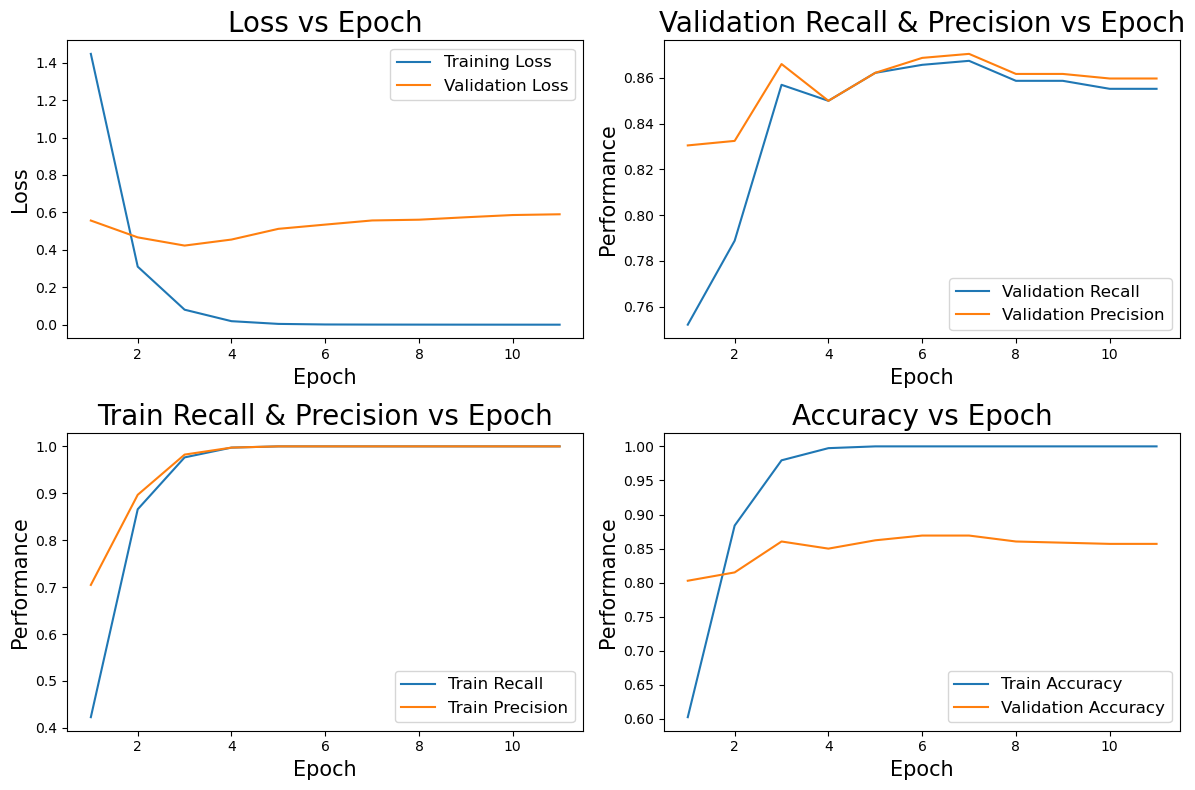

72/72 [==============================] - 3s 40ms/step - loss: 0.0240 - precision: 0.9991 - recall: 0.9991 - accuracy: 0.9991


c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 39ms/step - loss: 0.4228 - precision: 0.8660 - recall: 0.8569 - accuracy: 0.8604


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.023977,99.912930,99.912930,99.912930
1,Test,2.880321,66.753244,65.228426,65.736043
2,Validation,0.422785,86.596119,85.689354,86.038393


In [9]:
from functions import train_model, model_evaluate, view_history

conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version1')

# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

It seems that our might be overfitting. We can tell because the val_loss curve does not decrease but rather starts increasing. Lets reduce the complexity of the model to see if it helps.

# CNN Version 2